# Problem Definition

Use historical boxscores to predict an NBA player's Made Threes Per Second (MTPS) in a single game. In conjunction with the predicted NBA player's Seconds Played (SP) will be used to predict the total made threes of a player in a single game.

### Usage

- The final made threes projection will be used along other stat projections to predict a player's Daily Fantasy Sports (DFS) Fantasy Score. 
- The projection will also be used to bet on vegas lines.

# Setup

Import the necessary libraries

In [1]:
# for data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Factor Determination
Determine the factors that influence a player's Made Threes Per Second (MTPS).

- Historical MTPS
    - Season average
    - Recent performances (hot streaks)
    - Home vs. Away
    - Start vs. Bench
    - Rest
    - Historical Atempted Threes Per Second (ATPS)


- Defense
    - Defensive MTPS allowed
        - Starters vs. Bench players
        - By position
        - By cluster
    - Vegas game total

        
- Injuries
    - TPAPS of players playing vs average ATPS of team
    - Player MTPS/ATPS by starting lineup

# Data Analysis
Summarize the characteristics of the dataset.

First, I will pull the boxscore data and drop the unessesary rows.

In [2]:
query_data = QueryData()
clean_data = CleanData()

# pull boxscore data
boxscores = query_data.query_boxscore_data()

# we are only interested in the boxscores of healthy and non-resting players
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

pd.set_option('display.max_columns', None)
display(boxscores.head())

/Users/brandonshimiaie/Projects/sqlite/db/nba.db
2.6.0


,PLAYERID,TEAM,GAMEID,OPP_TEAM,COMMENT,START,SECONDSPLAYED,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PCT_AST_2PM,PCT_AST_3PM,OREB,OREB_PCT,DREB,DREB_PCT,AST,AST_PCT,AST_RATIO,STL,BLK,TOV,PF,PLUSMINUS,USG_PCT,PACE,ID_x,SEASON,DATE,HTM,VTM,W,ID_y,NAME,POSITION,SCHOOL,COUNTRY,HEIGHT,WEIGHT,DRAFTYEAR,DRAFTROUND,DRAFTNUMBER,BIRTHDATE
0,203906,ORL,0021400001,NOP,,0,179,4,2,2,0,0,0,2,0,0,2,4,0.500,0.0,0,0.000,1.0,0.333,0,0.000,0.0,0,0,0,1,4,0.300,112.63,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,203906,Devyn Marble,Forward,Iowa,USA,78,200,2014,2,56,1992-09-21
1,2584,ORL,0021400001,NOP,,0,247,0,0,1,0,0,0,0,0,0,0,0,0.000,0.0,1,0.250,1.0,0.100,0,0.000,0.0,0,0,0,0,-3,0.100,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,2584,Willie Green,Guard,Detroit Mercy,USA,75,205,2003,2,41,1981-07-28
2,202690,NOP,0021400001,ORL,,0,1068,2,0,6,0,3,2,2,0,0,0,0,0.000,0.0,0,0.000,0.0,0.000,2,0.133,22.2,1,0,0,3,3,0.146,98.43,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202690,Jimmer Fredette,Guard,Brigham Young,USA,74,195,2011,1,10,1989-02-25
3,202699,ORL,0021400001,NOP,,1,2192,25,9,18,1,2,6,6,6,5,8,16,0.625,1.0,2,0.048,6.0,0.111,0,0.000,0.0,1,0,4,2,-4,0.289,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202699,Tobias Harris,Forward,Tennessee,USA,80,226,2011,1,19,1992-07-15
4,201950,NOP,0021400001,ORL,,1,1622,8,4,11,0,3,0,0,2,2,2,6,0.250,0.0,0,0.000,2.0,0.067,4,0.190,23.5,3,1,2,2,9,0.188,94.99,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,201950,Jrue Holiday,Guard,UCLA,USA,75,205,2009,1,17,1990-06-12


I need to determine the type of each column, as well as the proportion of missing data.

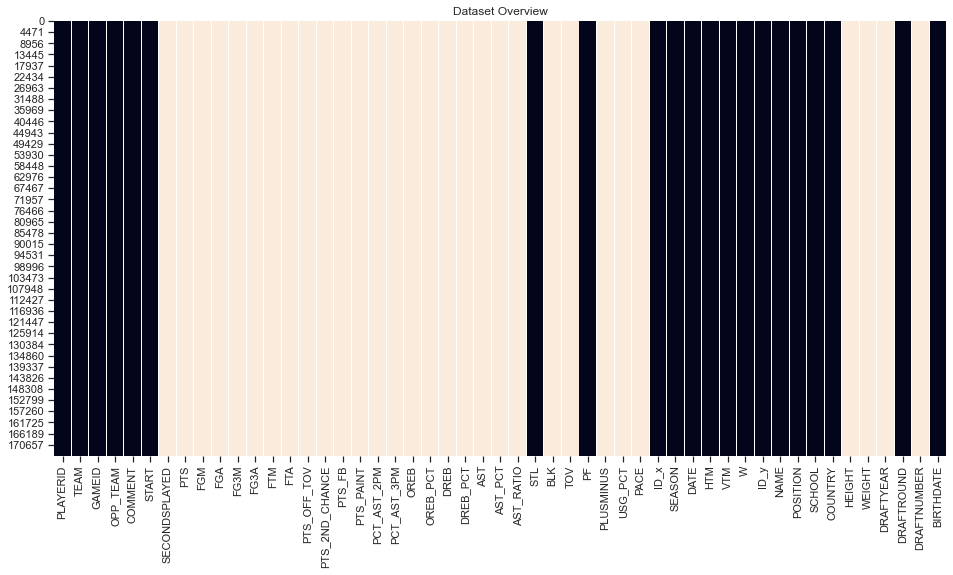

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [3]:
helpers = Helpers()

plt.rcParams["figure.figsize"] = (16, 8)
helpers.visualize_dataframe(boxscores)

Great, there is no missing data.

Next I will create the column of our dependant variable, $MTPS$.

In [4]:
y = 'Y'
boxscores[y] = boxscores['FG3M']/boxscores['SECONDSPLAYED']

Let's take a look at the distribution of values of our dependant variable. I will use a histogram to to visualize the probability density distribution of the outcomes of $Y$, and a box plot to graph data groups and outliers.

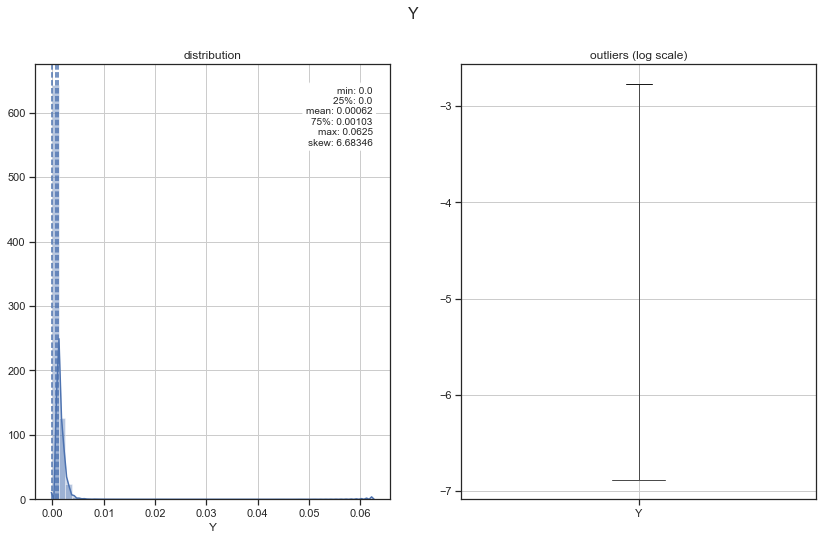

In [5]:
helpers.visualize_variable_distribution(boxscores, y, figsize=(14, 8))

Yikes.

There is clearly an abundance of outliers on the right side of the distribution.

My first guess of the cause of the plethora of outliers is that those outliers come from boxscores in which the player played very few seconds. For example, if a player played for 8 seconds, and made 1 three, his $MTPS$ would be 0.125. That would be an outlier in our distribtion.

Below shows the $MTPS$ distribution across different playing times.

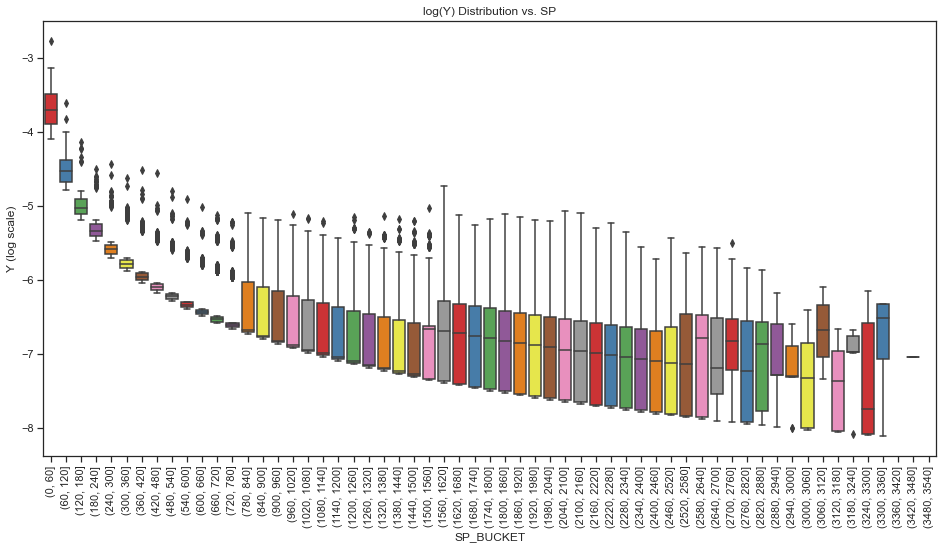

In [6]:
sp_max = boxscores['SECONDSPLAYED'].max()
max_bucket = int(60 * round(float(sp_max)/60))
buckets = [i for i in range(0, max_bucket, 60)]

temp = boxscores[[y, 'SECONDSPLAYED']]
temp['Y (log scale)'] = temp[y].apply(lambda x: np.log(x) if x > 0 else np.nan)
temp['SP_BUCKET'] = pd.cut(temp['SECONDSPLAYED'], buckets)

ax = sns.boxplot(x="SP_BUCKET", y="Y (log scale)", data=temp, palette="Set1")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.title.set_text('log(Y) Distribution vs. SP')
plt.show()
plt.close()

It seems as though the outliers are coming from the (0, 60] seconds played bucket. Let's remove those values from our set of outcomes, and replot the distributions.

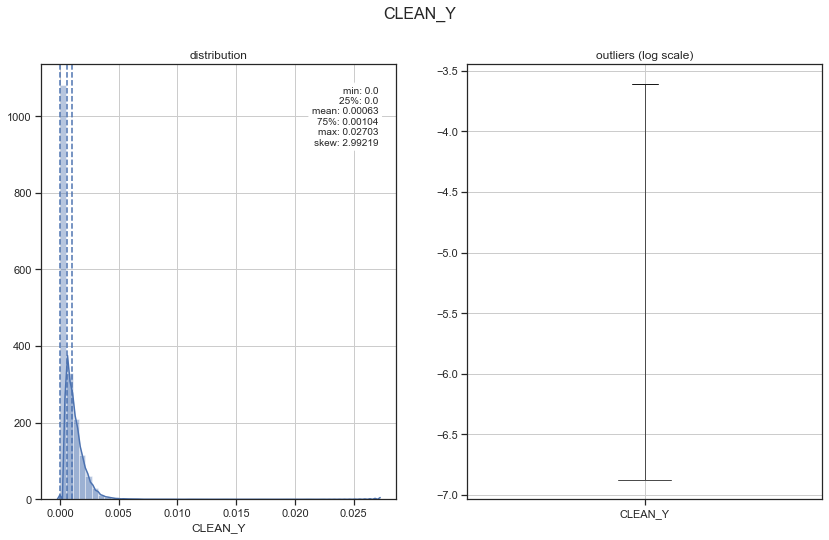

In [7]:
sp_threshold = 60

clean_y = 'CLEAN_Y'
boxscores[clean_y] = boxscores[y]
boxscores.loc[boxscores['SECONDSPLAYED'] <= sp_threshold, clean_y] = np.nan
helpers.visualize_variable_distribution(boxscores, clean_y, figsize=(14, 8))

This distribution looks better. We have far less positive outliers.

However, the distribution is still very skewed right and contains many outliers much higher than our mean.

Let's try looking at the distribtion of log outcomes.

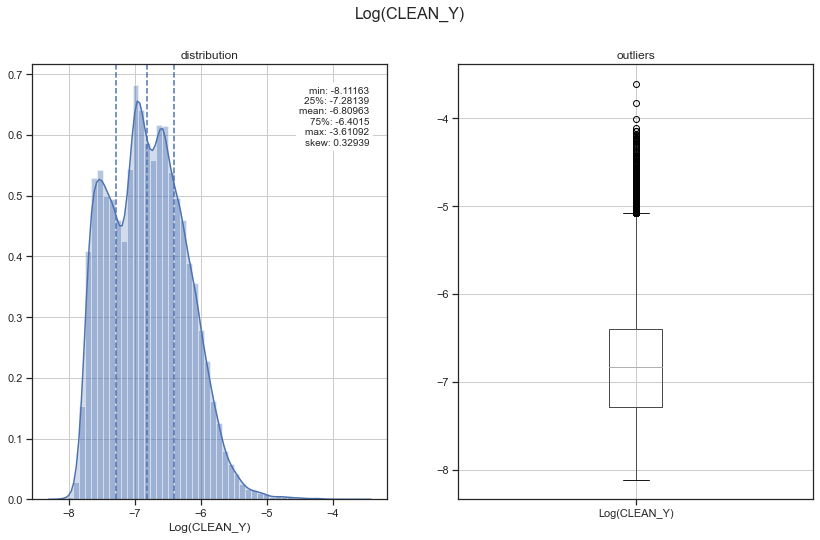

In [8]:
boxscores['Log(CLEAN_Y)'] = np.log(boxscores[clean_y])
boxscores['Log(CLEAN_Y)'] = boxscores['Log(CLEAN_Y)'].replace(-np.inf, np.nan)

helpers.visualize_variable_distribution(boxscores, 'Log(CLEAN_Y)', log_boxplot=False, figsize=(14, 8))

In [9]:
stat, p = shapiro(boxscores['Log(CLEAN_Y)'].dropna())
print(stat, p)

0.9806156754493713 0.0


Much better.

The distribution now contains a roughly equal amount of outliers on the left and right side, is less skewed, and is statistically normal.

# Feature Engineering
Create new features from raw data using domain knowlege.

In [10]:
regressors = []
categorical_regressors = []

### Historical MTPS
First, I will create features based on a player's historical $MTPS$.

I will start by calculating the running $MTPS$ of a player in a season.

In [11]:
feature_creation = FeatureCreation()

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y'
)

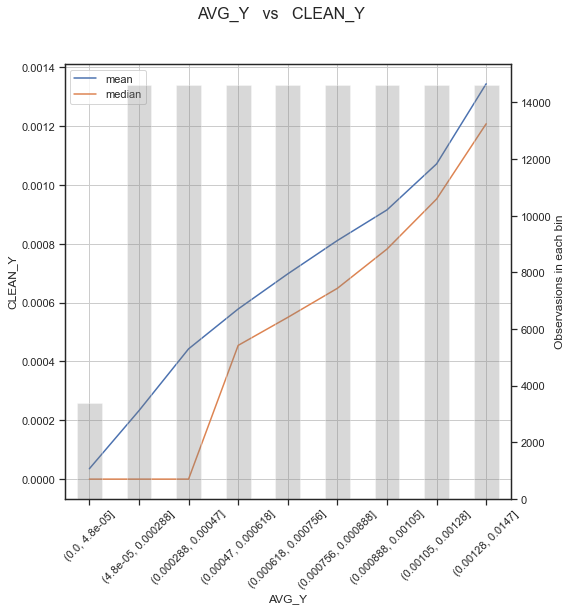

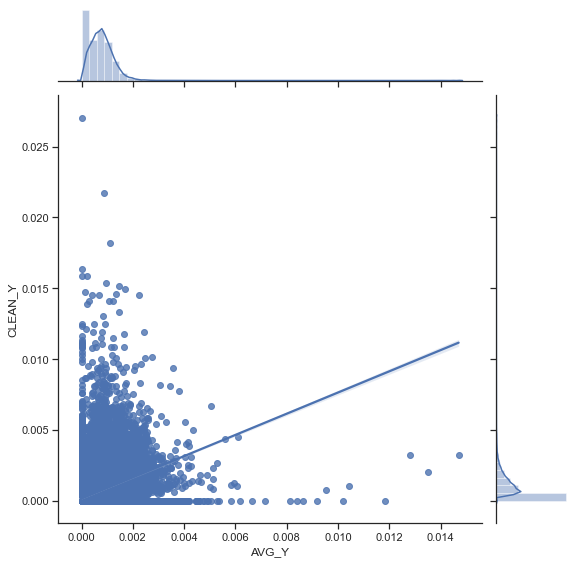

In [12]:
helpers.visualize_numeric_x_vs_y(boxscores.loc[boxscores['AVG_Y'] < 0.1], 'AVG_Y', clean_y, figsize=(8, 8))

In [13]:
regressors.append('AVG_Y')

Next, I will calculate the $MTPS$ of a player in the previous games against the same opposing team in the same season.

In [14]:
boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'OPP_TEAM', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_OPP_TEAM'
)
regressors.append('AVG_Y_OPP_TEAM')

Do more recent Y values within a season matter more than previous ones?

To answer this, first I will calculate the Autocorrelation of $Y$ and previous lags of $Y$:

$$ ACF(Y_{0}, Y_{i}) $$ <br>

Then, I will calculate the Partial Autocorrelation between $Y$ and previous lags of $Y$, using the lags in between as covariates:

$$ PACF(Y_{0}, Y_{i}  |  \{Y_{j}\}_{0<j<i}) $$ <br>

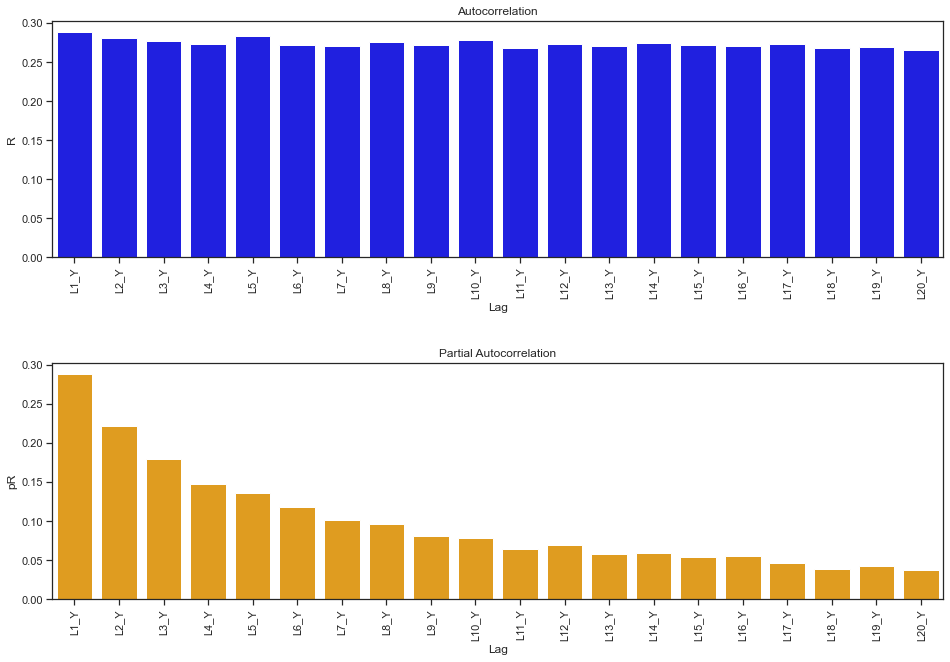

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(14, 10))

x_ticks = []
corrs = []
p_corrs = []
for i in range(1, 21):
    x = 'L{}_{}'.format(str(i), y)

    boxscores = feature_creation.lag(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=clean_y, new_col_name=x, n_shift=i
    )
    
    corr = boxscores[clean_y].corr(boxscores[x])
    p_corr = pg.partial_corr(data=boxscores, x=x, y=clean_y, covar=x_ticks)
    
    corrs.append(corr)
    p_corrs.append(p_corr['r'][0])
    x_ticks.append(x)
    
corr_df = pd.DataFrame({'R': corrs, 'pR': p_corrs, 'Lag': x_ticks})

sns.barplot(x='Lag', y='R', data=corr_df, color='blue', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].title.set_text('Autocorrelation')

sns.barplot(x='Lag', y='pR', data=corr_df, color='orange', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].title.set_text('Partial Autocorrelation')

fig.tight_layout(pad=3.0)
plt.show()
plt.close()

While the Autocorrelaton of each between $Y$ and each $Y_{i}$ is similar, the Partial Autocorrelations exponentially decrease. This tells us that each $Y_{i}$ tells us less new information than the preceding lag does. This is a reason for us to add the first lag of Y to our list of regressors. It also makes the case that an exponentially weighted mean of previous $Y$ lags may be more predictive of $Y$ than a normal mean.

In [16]:
regressors.append('L1_Y')
    
boxscores = feature_creation.expanding_ewm(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, new_col_name='EWM_Y', alpha=0.90
)
regressors.append('EWM_Y')

Next, I will calculate the partial correlation between $Y$ and previous moveing averages of $Y$, using a covariate of the AVG_$Y$. The peak of this graph will tell us which MA provides the most new information on top of AVG_$Y$.

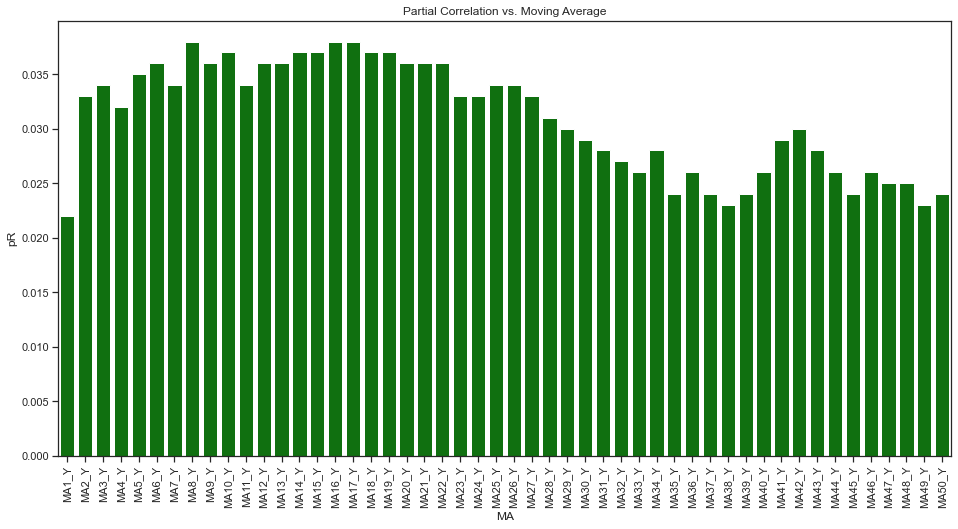

In [17]:
x_ticks = []
p_corrs = []
for i in range(1, 51):
    x = 'MA{}_{}'.format(str(i), y)

    boxscores = feature_creation.rolling_weighted_mean(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, new_col_name=x,
        weight_col_name='SECONDSPLAYED', n_rolling=i, min_periods=math.ceil(i/2)
    )
    
    p_corr = pg.partial_corr(data=boxscores, x=x, y=clean_y, covar=['AVG_Y'])
    
    x_ticks.append(x)
    p_corrs.append(p_corr['r'][0])
    
corr_df = pd.DataFrame({'pR': p_corrs, 'MA': x_ticks})
ax = sns.barplot(x='MA', y='pR', data=corr_df, color='green')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.title.set_text('Partial Correlation vs. Moving Average')
plt.show()
plt.close()

I will use MA2_$Y$ and MA8_$Y$. Lower moveing averages are more convinient to use than higher ones because we need less data points to calculate them.

In [18]:
regressors.append('MA2_Y')
regressors.append('MA8_Y')

Now I will determine if the dependant variable, $Y$, depends on various categorical variables in our data set.

First I will visualize the difference of the distributions and means of $Y$ when a player is playing at Home or Away.

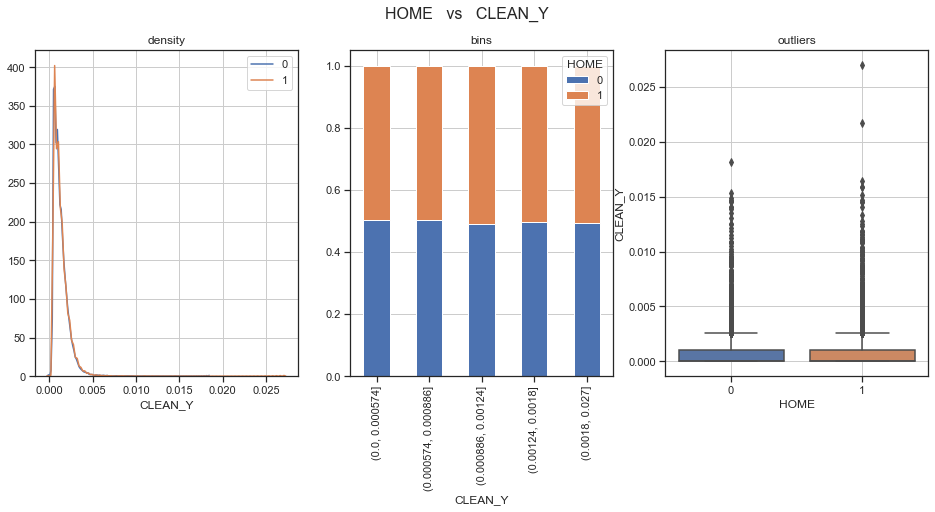

In [19]:
boxscores['HOME'] = 0
boxscores.loc[boxscores['TEAM'] == boxscores['HTM'], 'HOME'] = 1
helpers.visualize_categorical_x_vs_y(boxscores, 'HOME', clean_y)

There does not seem to be a relationship between the location a player plays at and his $MTPS$.

Next I will determine if a player's $MTPS$ depends on his status as a Starter.

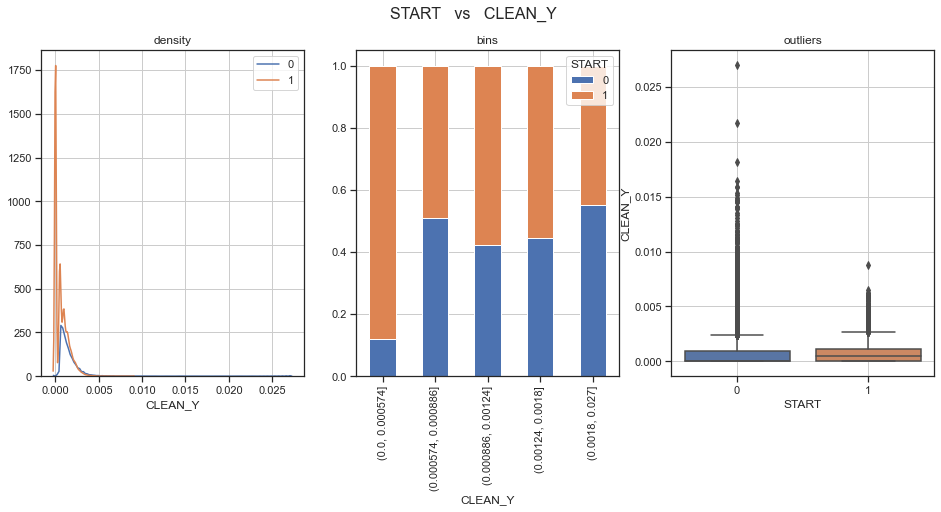

In [20]:
helpers.visualize_categorical_x_vs_y(boxscores, 'START', clean_y)

At a glance, it seems like there may be a slight relationship between starting status and $MTPS$.

To confirm this hypothesis, I will investigate the percentage of (season, player) groups in the dataset exhibit a statistically significant difference between their mean $MTPS$ when they start and are benched. To test significance, I will use a one-way ANOVA test.

In [21]:
num_valid_player_seasons = 0
significant_player_seasons = []
a = 0.01
for player_season, temp in boxscores.groupby(['SEASON', 'PLAYERID']):
    anova = pg.anova(dv=y, between='START', data=temp, detailed=False)
    p = anova['p-unc'].iloc[0]
    if p != '-':
        num_valid_player_seasons += 1
        if float(p) < a:
            significant_player_seasons.append(player_season)

print('Number of significant (season, player) combinations:', len(significant_player_seasons))
print('Percentage of significant (season, player) combinations:', len(significant_player_seasons)/num_valid_player_seasons)

Number of significant (season, player) combinations: 60
Percentage of significant (season, player) combinations: 0.03865979381443299


The percentage of (season, player) combinations that exibit a significant difference is 3.66%, almost twice our alpha of 1%. This is enough to add a categorical variable that identifies if a player is starting, 'START', to the list of regressors. I will also add the season average $MTPS$ of a player in the role he is playing to our list of regressors. I will call this variable: $AVG\_Y\_R$.

In [22]:
regressors.append('START')
categorical_regressors.append('START')

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID', 'START'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_R'
)
regressors.append('AVG_Y_R')

Next, I will determine if the number of days a player rests is indicative of his $MTPS$.

In [23]:
boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DATE', new_col_name='LAST_DATE'
)
boxscores['LAST_DATE'] = boxscores['LAST_DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)
boxscores['DATE'] = boxscores['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores['REST'] = boxscores[['DATE', 'LAST_DATE']].apply(
    lambda x: max(min((x[0] - x[1]).days, 5), 1) if not (isinstance(x[0], str) or isinstance(x[1], str)) else np.nan,
    axis=1
)

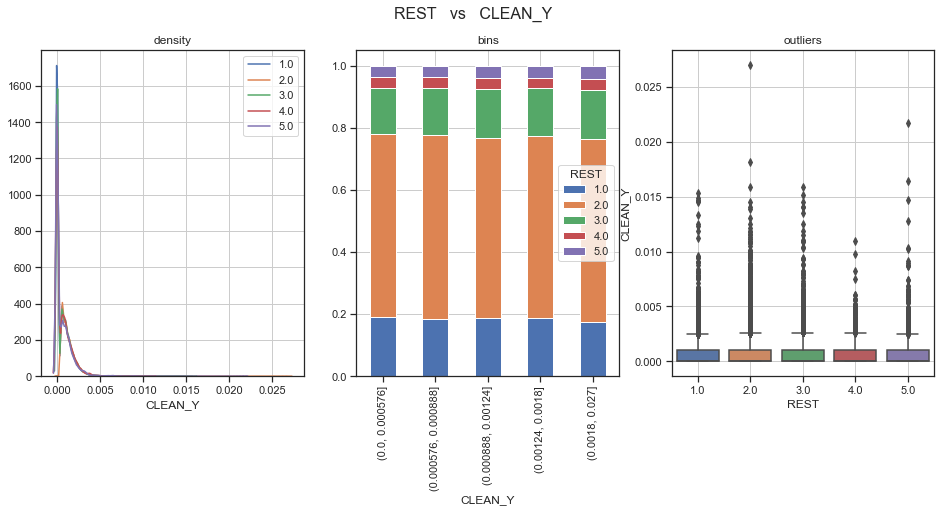

In [24]:
helpers.visualize_categorical_x_vs_y(boxscores, 'REST', clean_y)

No significant relationship.

What if a player's shooting volume has been high, but he has been shooting poorly? His recent $MTPS$ performances may be low/average, but if the volume continues and his slump ends, his $MTPS$ would increase.

In [25]:
boxscores['ATPS'] = boxscores['FG3A']/boxscores['SECONDSPLAYED']

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='ATPS', new_col_name='AVG_ATPS', weight_col_name='SECONDSPLAYED'
)

boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='ATPS', new_col_name='L1_ATPS', n_shift=1
)

boxscores = feature_creation.rolling_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='ATPS', new_col_name='MA3_ATPS',
    weight_col_name='SECONDSPLAYED', n_rolling=3, min_periods=2
)

regressors.append('AVG_ATPS')
regressors.append('L1_ATPS')
regressors.append('MA3_ATPS')


boxscores['FG3%'] = boxscores['FG3M']/boxscores['FG3A']

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='FG3%', new_col_name='AVG_FG3%', weight_col_name='FG3A'
)

boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='FG3%', new_col_name='L1_FG3%', n_shift=1
)

boxscores = feature_creation.rolling_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='FG3%', new_col_name='MA3_FG3%',
    weight_col_name='FG3A', n_rolling=3, min_periods=2
)

regressors.append('AVG_FG3%')
regressors.append('L1_FG3%')
regressors.append('MA3_FG3%')

### Defense
Next, I will create features that measure the defense of the opposing team.

First, I will calculate the defense of each team on a game-to-game basis. I will define defense as:

$$TEAM\_Y\_DIFF\_ALLOWED =  TEAM\_Y\_ALLOWED - TEAM\_Y\_AVG$$

where $TEAM\_Y\_ALLOWED$ is the $MTPS$ allowed to the opposing team and $TEAM\_Y\_AVG$ is the $MTPS$ of that team throughout the season coming into the game.

In [26]:
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='FG3M', new_col_name='AVG_FG3M'
)
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SECONDSPLAYED', new_col_name='AVG_SP'
)

temp = boxscores.dropna(subset=['FG3M', 'SECONDSPLAYED', 'AVG_FG3M', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_Y_ALLOWED': x['FG3M'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_Y_AVG': x['AVG_FG3M'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_Y_DIFF_ALLOWED'] = grouped_defensive_boxscores['TEAM_Y_ALLOWED'] - grouped_defensive_boxscores['TEAM_Y_AVG']

Next, I will visualize the defense of each team for each season in the dataset. I will also run a one-way ANOVA test to determine if the mean $TEAM\_Y\_DIFF\_ALLOWED$ differs among the teams in each season.

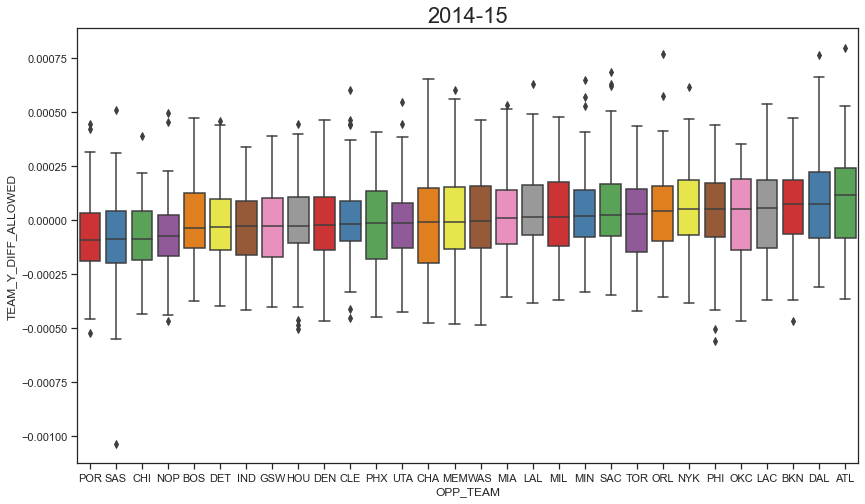

Team defenses are statistically siginficantly different


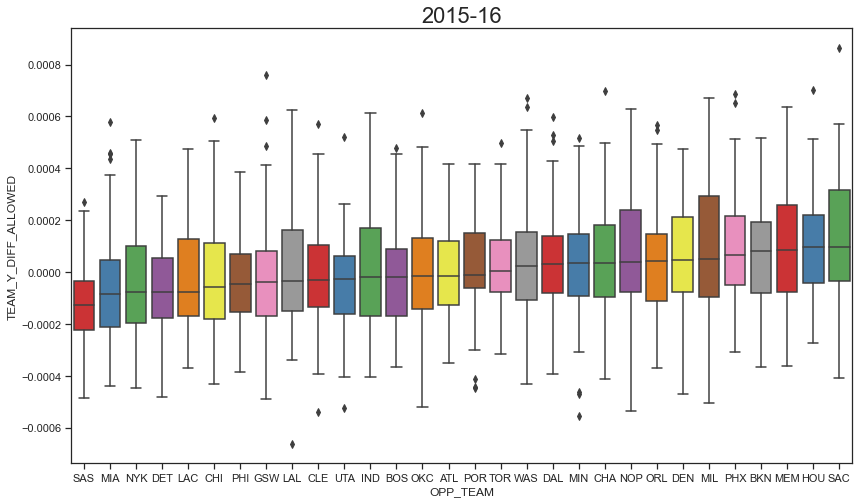

Team defenses are statistically siginficantly different


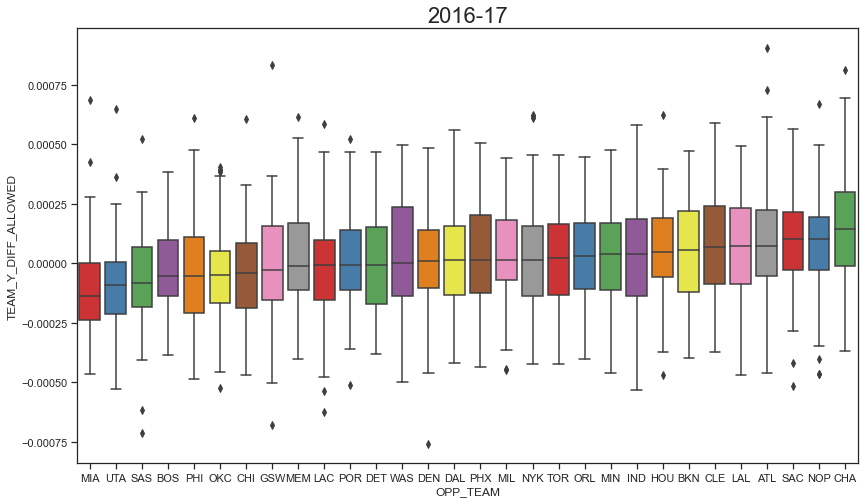

Team defenses are statistically siginficantly different


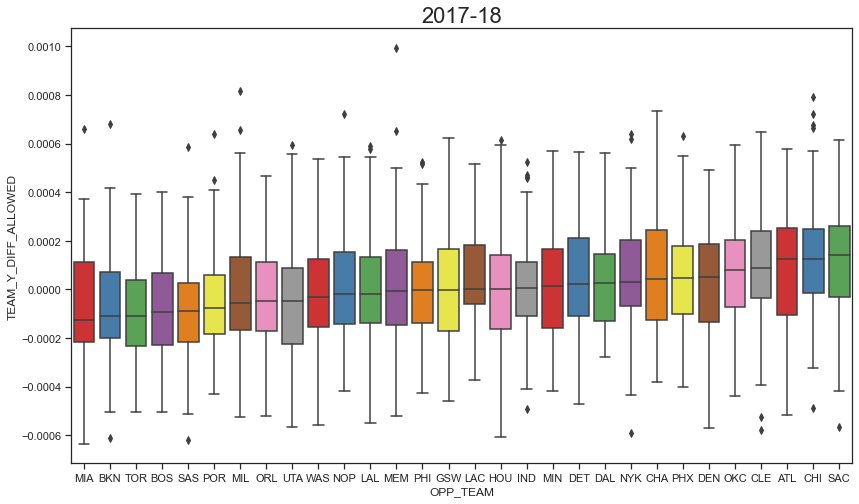

Team defenses are statistically siginficantly different


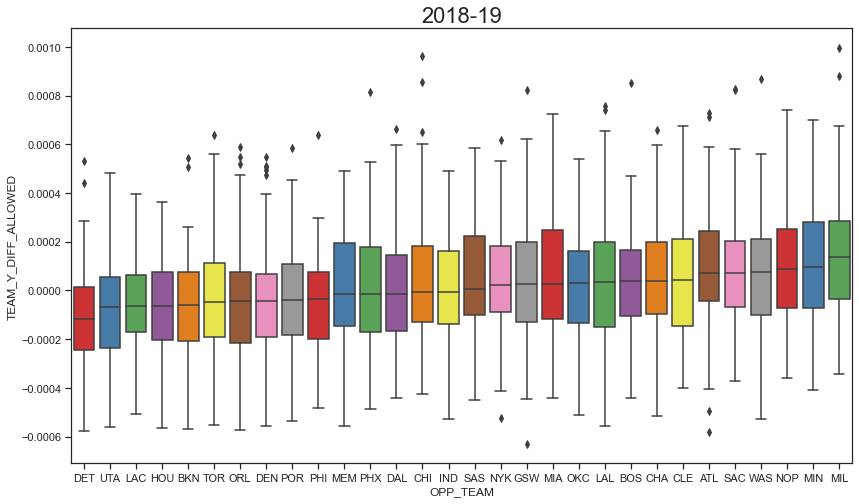

Team defenses are statistically siginficantly different


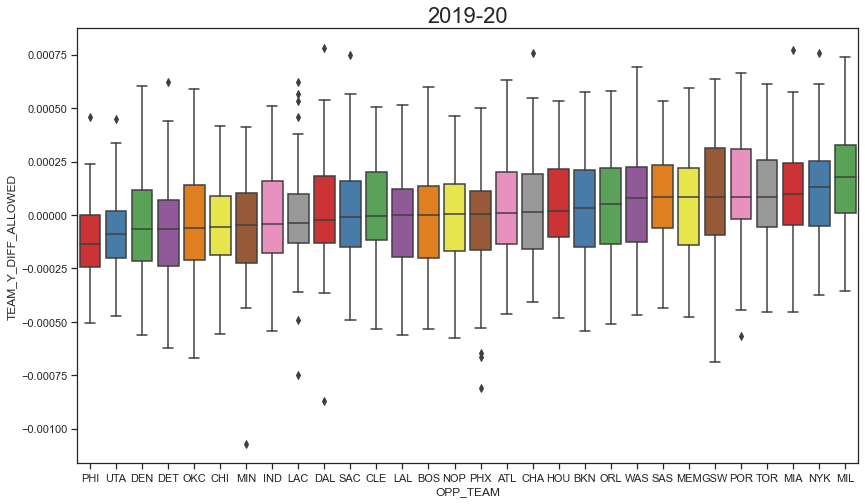

Team defenses are statistically siginficantly different


In [27]:
a = 0.01
for season, temp in grouped_defensive_boxscores.groupby(['SEASON']):
    plt.figure(figsize=(14, 8))
    plt.title(season,fontsize=22)
    opp_team_def = [
        (opp_team, temp2['TEAM_Y_DIFF_ALLOWED'].median()) for opp_team, temp2 in temp.groupby('OPP_TEAM')
    ]
    opp_team_def.sort(key = lambda x: x[1])
    opp_teams = [i[0] for i in opp_team_def]
    sns.boxplot(x="OPP_TEAM", y="TEAM_Y_DIFF_ALLOWED", data=temp, palette="Set1", order=opp_teams)
    
    plt.show()
    plt.close()
    
    anova = pg.anova(dv='TEAM_Y_DIFF_ALLOWED', between='OPP_TEAM', data=temp, detailed=True)
    p = anova['p-unc'].iloc[0]
    if p < a:
        print('Team defenses are statistically siginficantly different')
    else:
        print('Team defenses are not statistically siginficantly different')

The average defenses of each team seem to be significantly different from each other each season.

Now, I will create calculate the average defense of the opposing team across all previous games in a season, $AVG\_TEAM\_Y\_DIFF\_ALLOWED$. Then, I will visualize it's correlation with the dependant variable.

In [28]:
grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM'], col_name='TEAM_Y_DIFF_ALLOWED', new_col_name='AVG_TEAM_Y_DIFF_ALLOWED',
    order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM'], how='left')

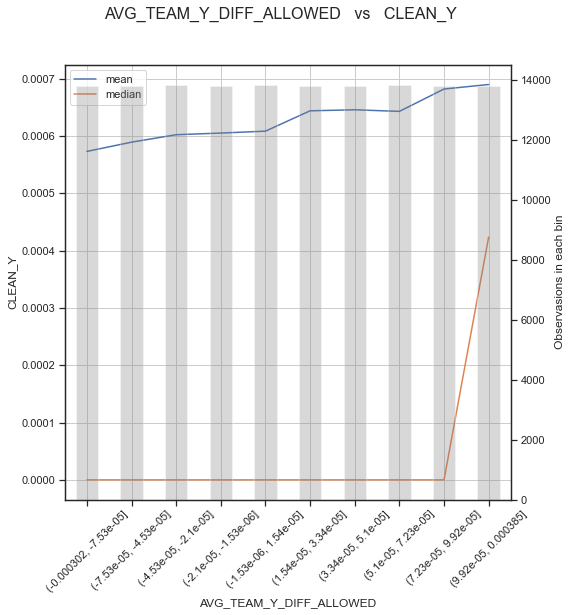

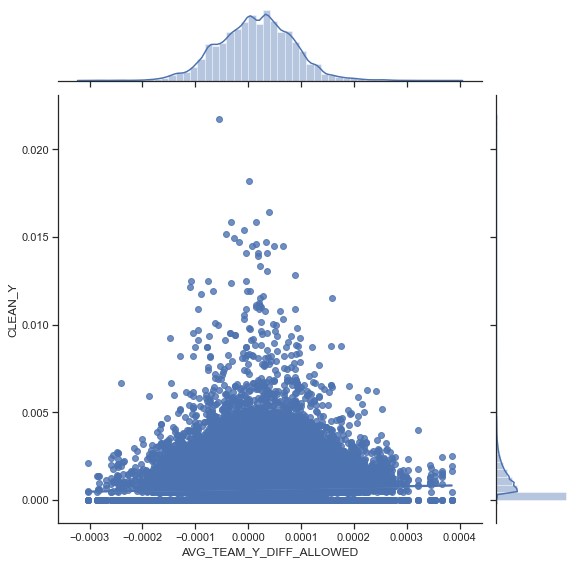

In [29]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_Y_DIFF_ALLOWED', clean_y, figsize=(8, 8))

In [30]:
regressors.append('AVG_TEAM_Y_DIFF_ALLOWED')

Opposing teams may also defend different positions differently.

I will use the variable $TEAM\_Y\_DIFF\_ALLOWED\_P$ to quantify a team's defense on opposing players by role (guard/forward/center).

In [31]:
boxscores['NORM_POS'] = boxscores['POSITION'].apply(lambda x: x if '-' not in x else x.split('-')[0])

temp = boxscores.dropna(subset=['FG3M', 'SECONDSPLAYED', 'AVG_FG3M', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'NORM_POS', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_Y_ALLOWED_P': x['FG3M'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_Y_AVG_P': x['AVG_FG3M'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_Y_DIFF_ALLOWED_P'] = grouped_defensive_boxscores['TEAM_Y_ALLOWED_P'] - grouped_defensive_boxscores['TEAM_Y_AVG_P']

grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM', 'NORM_POS'], col_name='TEAM_Y_DIFF_ALLOWED_P',
    new_col_name='AVG_TEAM_Y_DIFF_ALLOWED_P', order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM', 'NORM_POS'], how='left')

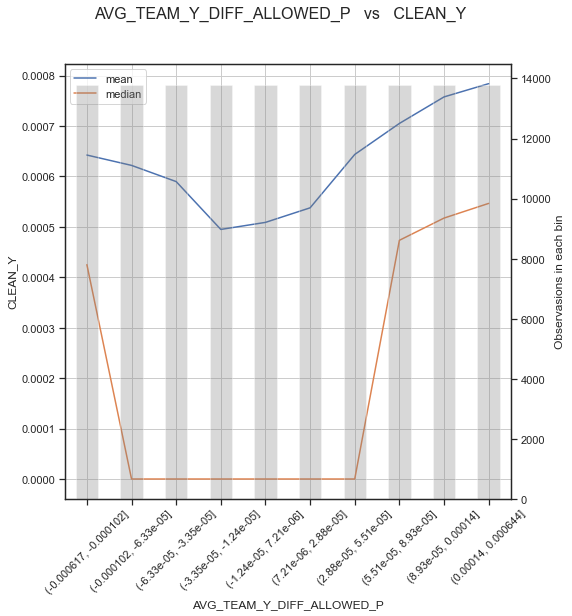

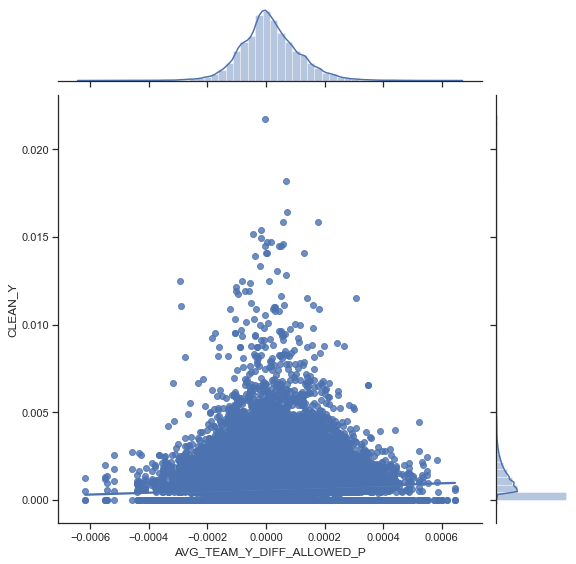

In [32]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_Y_DIFF_ALLOWED_P', clean_y, figsize=(8, 8))

In [33]:
regressors.append('AVG_TEAM_Y_DIFF_ALLOWED_P')

I will also include the vegas implied game point total as a feature.

In [34]:
odds = query_data.query_odds_data()
odds['TOTAL'] = odds['TOTAL'].replace(['PK', '-'], np.nan)
full_game_odds = odds.loc[odds['PERIOD'] == 'Full Game']

In [35]:
full_game_odds['DATE'] = full_game_odds['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores = boxscores.merge(full_game_odds, on=['DATE', 'TEAM'], how='left')

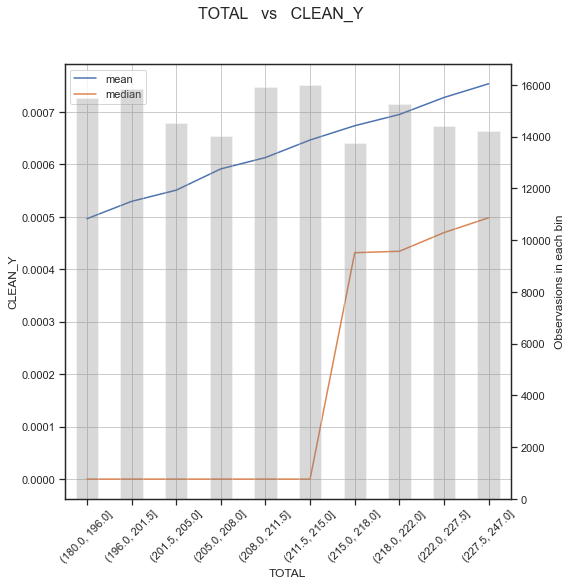

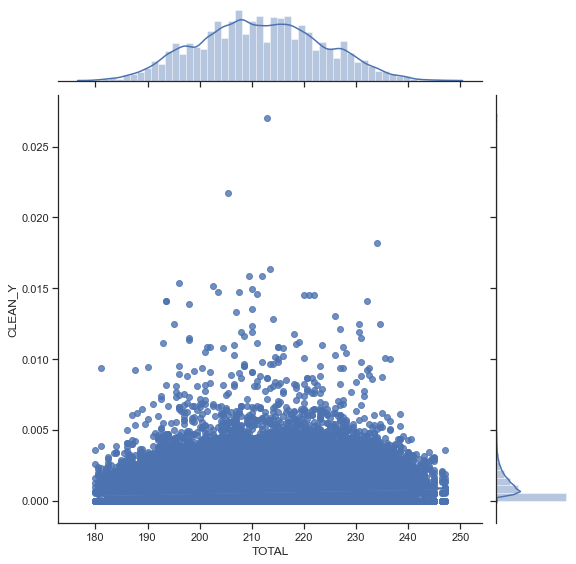

In [36]:
helpers.visualize_numeric_x_vs_y(boxscores, 'TOTAL', clean_y, figsize=(8, 8))

In [37]:
regressors.append('TOTAL')

### Injuries
Finally, I will create features that quantify how injured the lineup is from a production standpoint.

The first variable I will create to capture how injured the lineup is will be called $TEAM\_ACTIVE\_AVG\_ATPS\_DIFF$. This will capture the difference between the ATPS of the players of a team active in a game, and the average ATPS of that team. For example, if the sum of the average seconds played of the active players on a team was 14400, and the sum of the average Attempted Threes of the active players on the team was 60, the $TEAM\_ACTIVE\_AVG\_ATPS$ would be $60/14400 = 0.00417$. If the next game, James Harden was out (who is on the team and averaged 2000 seconds played and 10 Attempted Threes) the $TEAM\_ACTIVE\_AVG\_ATPS$ would be $(60-10)/(14400-2000) = 0.00403$. In this case $TEAM\_ACTIVE\_AVG\_ATPS\_DIFF$ would be $0.00417-0.00403 = -0.000138$. This lower number would hopefully be more indicative of a higher $MTPS$ for the rest of the team.

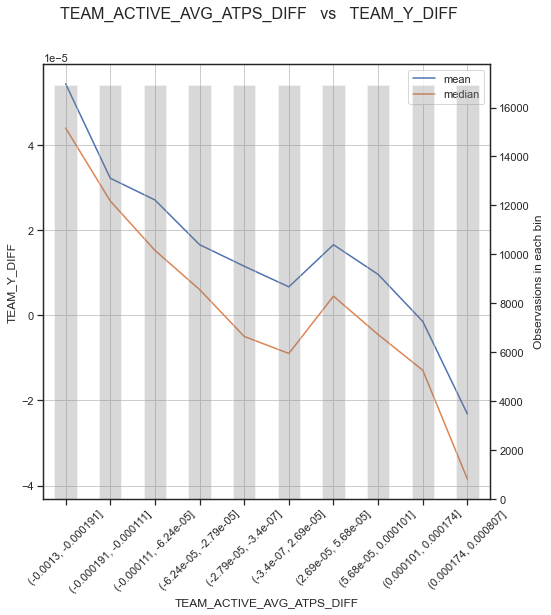

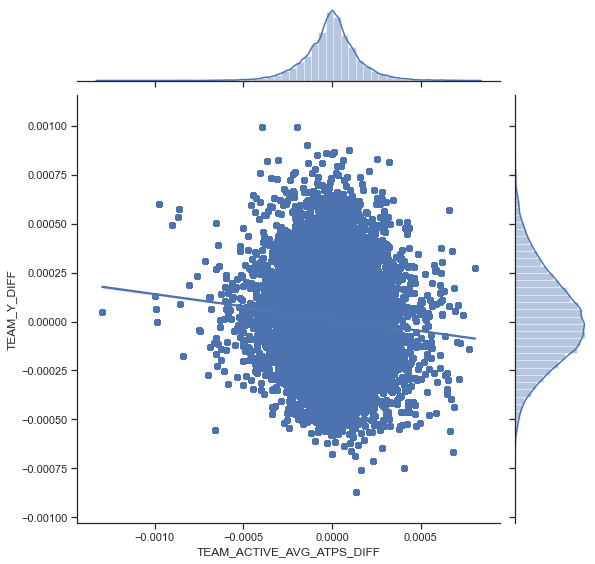

In [38]:
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='FG3A', new_col_name='AVG_FG3A'
)

temp = boxscores.dropna(subset=['AVG_SP', 'AVG_FG3A', 'FG3A', 'SECONDSPLAYED'])
temp = temp.groupby(['SEASON', 'GAMEID', 'TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_ACTIVE_AVG_ATPS': x['AVG_FG3A'].sum()/x['AVG_SP'].sum(),
        'TEAM_ATPS': x['FG3A'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_ACTIVE_AVG_Y': x['AVG_FG3M'].sum()/x['AVG_SP'].sum(),
        'TEAM_Y': x['FG3M'].sum()/x['SECONDSPLAYED'].sum()
    })
)
temp = feature_creation.expanding_mean(
    df=temp, group_col_names=['SEASON', 'TEAM'], col_name='TEAM_ATPS', new_col_name='AVG_TEAM_ATPS'
)
temp['TEAM_ACTIVE_AVG_ATPS_DIFF'] = temp['TEAM_ACTIVE_AVG_ATPS'] - temp['AVG_TEAM_ATPS']
temp['TEAM_Y_DIFF'] = temp['TEAM_Y'] - temp['TEAM_ACTIVE_AVG_Y']

boxscores = boxscores.merge(temp, on=['GAMEID', 'TEAM'], how='left')
helpers.visualize_numeric_x_vs_y(boxscores, 'TEAM_ACTIVE_AVG_ATPS_DIFF', 'TEAM_Y_DIFF', figsize=(8, 8))

It seems as though a lower $TEAM\_ACTIVE\_AVG\_ATPS\_DIFF$ is indicative of a higher $TEAM\_Y$ than the active players average. I will add this to my list of regressors.

In [39]:
regressors.append('TEAM_ACTIVE_AVG_ATPS_DIFF')

Not all players absorb lost usage equally. To account for this, I will create features that track the $AVG\_MTPS$ and $AVG\_ATPS$ of players when the starting lineup was the same. I will also create features that track the $AVG\_MTPS$ and $AVG\_ATPS$ of players when the active star players on the team were the same (I will define 'star player' in this context as a player who averages over 20 Points Per Game).

In [40]:
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='PTS', new_col_name='AVG_PTS'
)

boxscores['START_LINEUP'] = np.nan
boxscores['STARS'] = np.nan
boxscores = boxscores.set_index(['GAMEID', 'TEAM'])
for (game_id, team), temp in boxscores.groupby(['GAMEID', 'TEAM']):
    start_lineup = list(temp.loc[temp['START'] == 1, 'PLAYERID'].values)
    start_lineup.sort()
    start_lineup = '_'.join(start_lineup)
    boxscores.loc[(game_id, team), 'START_LINEUP'] = start_lineup
    
    stars = list(temp.loc[temp['AVG_PTS'] > 20, 'PLAYERID'].values)
    stars.sort()
    stars = '_'.join(stars)
    boxscores.loc[(game_id, team), 'STARS'] = stars
boxscores = boxscores.reset_index()

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'START_LINEUP', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_STARTERS'
)

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'STARS', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_STARS'
)

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'START_LINEUP', 'PLAYERID'], col_name='ATPS', weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_ATPS_STARTERS'
)

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'STARS', 'PLAYERID'], col_name='ATPS', weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_ATPS_STARS'
)

To determine if these features provide new information, I will calcuate the partial correlation between each of them and the dependant variable, using $AVG\_Y$ as the covariate.

In [41]:
print('Partial correlation between AVG_PPS_STARTERS and Y with covariate AVG_Y:')
pc = pg.partial_corr(data=boxscores, x='AVG_Y_STARTERS', y=clean_y, covar=['AVG_Y'])
display(pc)

print('Partial correlation between AVG_PPS_STARS and Y with covariate AVG_Y:')
pc = pg.partial_corr(data=boxscores, x='AVG_Y_STARS', y=clean_y, covar=['AVG_Y'])
display(pc)

print('Partial correlation between AVG_APS_STARTERS and APS with covariate AVG_APS:')
pc = pg.partial_corr(data=boxscores, x='AVG_ATPS_STARTERS', y='ATPS', covar=['AVG_ATPS'])
display(pc)

print('Partial correlation between AVG_APS_STARS and APS with covariate AVG_APS:')
pc = pg.partial_corr(data=boxscores, x='AVG_ATPS_STARS', y='ATPS', covar=['AVG_ATPS'])
display(pc)

Partial correlation between AVG_PPS_STARTERS and Y with covariate AVG_Y:


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,110230,0.025,"[0.02, 0.03]",0.001,0.001,1.279232e-16,2.804e+12,1.0


Partial correlation between AVG_PPS_STARS and Y with covariate AVG_Y:


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,140249,0.007,"[0.0, 0.01]",0.0,0.0,0.005828,0.15,0.787


Partial correlation between AVG_APS_STARTERS and APS with covariate AVG_APS:


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,111014,0.039,"[0.03, 0.05]",0.002,0.002,2.345186e-39,9.683e+34,1.0


Partial correlation between AVG_APS_STARS and APS with covariate AVG_APS:


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,141354,0.02,"[0.02, 0.03]",0.0,0.0,2.351859e-14,1.458e+10,1.0


These features show a significant partial correlation with the dependent variable. I will add them to the list of regressors.

In [42]:
regressors.append('AVG_Y_STARTERS')
regressors.append('AVG_Y_STARS')
regressors.append('AVG_ATPS_STARTERS')
regressors.append('AVG_ATPS_STARS')

### Weights
Lastly, I will add a column to weight each $Y$ value.

The weight I will use will be a product of functions of the amount of seconds played in a game and the sum of seconds played by a player throughout that season:

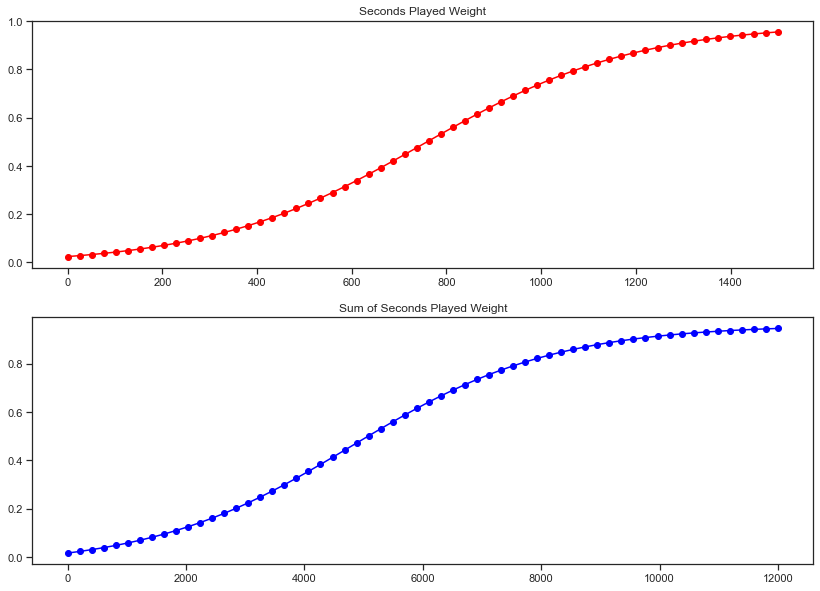

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(14, 10))

sp_weight_func = lambda x: 1/(1 + np.exp((-0.80*x + 600)/180)) - 0.01
sp_in_array = np.linspace(0, 60*25, 60)
sp_out_array = sp_weight_func(sp_in_array) 

tsp_weight_func = lambda x: 1/(1 + np.exp((-0.175*x + 840)/300)) - 0.04
tsp_in_array = np.linspace(0, 60*20*10, 60)
tsp_out_array = tsp_weight_func(tsp_in_array)

ax[0].title.set_text("Seconds Played Weight") 
ax[0].plot(sp_in_array, sp_out_array, color ='red', marker="o")

ax[1].title.set_text("Sum of Seconds Played Weight") 
ax[1].plot(tsp_in_array, tsp_out_array, color ='blue', marker="o") 
plt.show() 

In [44]:
boxscores = feature_creation.expanding_sum(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='SECONDSPLAYED', new_col_name='SUM_SP'
)

w = 'WEIGHT'
boxscores[w] = boxscores['SECONDSPLAYED'].apply(sp_weight_func) * boxscores['SUM_SP'].apply(tsp_weight_func)

Some features we created to track historical performances mean less if the player has played less games/ minutes. To tell the non-linear models how much the player has played, I will create 2 regressors: number of games played ($COUNT\_GP$) and average seconds played ($AVG\_SP$)

In [45]:
boxscores['GP'] = 1
boxscores = feature_creation.expanding_sum(df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='GP', new_col_name='COUNT_GP')
regressors.append('COUNT_GP')

regressors.append('AVG_SP')

# Preprocessing
Now that I have created all the features I found to be indicative of our dependant variable, I will prepare the data to be suitable for a predictive model.

The first thing I will do is handle missing data.

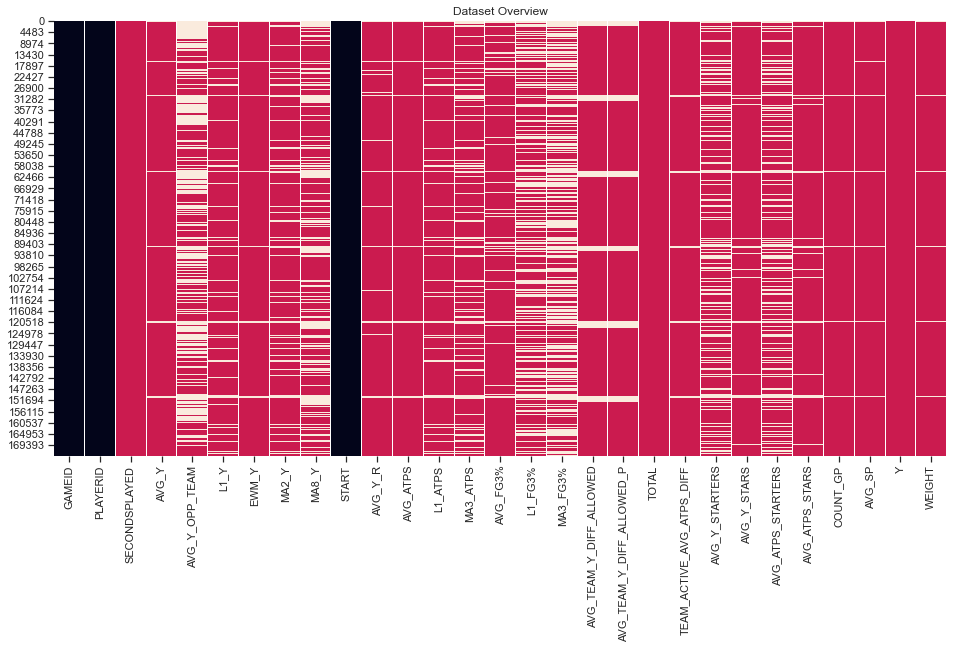

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 77.683


In [46]:
feature_matrix = boxscores[['GAMEID', 'PLAYERID', 'SECONDSPLAYED'] + regressors + [y] + [w]]

#drop games in which players played a minute or less
feature_matrix = feature_matrix.loc[feature_matrix['SECONDSPLAYED'] > 60]

helpers.visualize_dataframe(feature_matrix)

In [47]:
feature_matrix['AVG_Y_R'] = feature_matrix['AVG_Y_R'].fillna(feature_matrix['AVG_Y'])
feature_matrix['AVG_Y_OPP_TEAM'] = feature_matrix['AVG_Y_OPP_TEAM'].fillna(feature_matrix['AVG_Y'])
feature_matrix['L1_Y'] = feature_matrix['L1_Y'].fillna(feature_matrix['AVG_Y'])
feature_matrix['EWM_Y'] = feature_matrix['EWM_Y'].fillna(feature_matrix['AVG_Y'])
feature_matrix['MA2_Y'] = feature_matrix['MA2_Y'].fillna(feature_matrix['AVG_Y'])
feature_matrix['MA8_Y'] = feature_matrix['MA8_Y'].fillna(feature_matrix['MA2_Y'])

feature_matrix['L1_ATPS'] = feature_matrix['L1_ATPS'].fillna(feature_matrix['AVG_ATPS'])
feature_matrix['MA3_ATPS'] = feature_matrix['MA3_ATPS'].fillna(feature_matrix['AVG_ATPS'])

feature_matrix['AVG_FG3%'] = feature_matrix['AVG_FG3%'].fillna(feature_matrix['AVG_FG3%'].mean())
feature_matrix['L1_FG3%'] = feature_matrix['L1_FG3%'].fillna(feature_matrix['AVG_FG3%'])
feature_matrix['MA3_FG3%'] = feature_matrix['MA3_FG3%'].fillna(feature_matrix['AVG_FG3%'])

feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED'] = feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED'].fillna(0)
feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_P'] = feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_P'].fillna(0)

feature_matrix['TEAM_ACTIVE_AVG_ATPS_DIFF'] = feature_matrix['TEAM_ACTIVE_AVG_ATPS_DIFF'].fillna(0)

feature_matrix['AVG_Y_STARS'] = feature_matrix['AVG_Y_STARS'].fillna(feature_matrix['AVG_Y'])
feature_matrix['AVG_Y_STARTERS'] = feature_matrix['AVG_Y_STARTERS'].fillna(feature_matrix['AVG_Y_STARS'])
feature_matrix['AVG_ATPS_STARS'] = feature_matrix['AVG_ATPS_STARS'].fillna(feature_matrix['AVG_ATPS'])
feature_matrix['AVG_ATPS_STARTERS'] = feature_matrix['AVG_ATPS_STARTERS'].fillna(feature_matrix['AVG_ATPS_STARS'])

feature_matrix['COUNT_GP'] = feature_matrix['COUNT_GP'].fillna(0)

feature_matrix['TOTAL'] = feature_matrix['TOTAL'].fillna(200)

# we can predict Y for a player as long as AVG_Y is not nan
feature_matrix = feature_matrix.dropna(subset=['AVG_Y'])

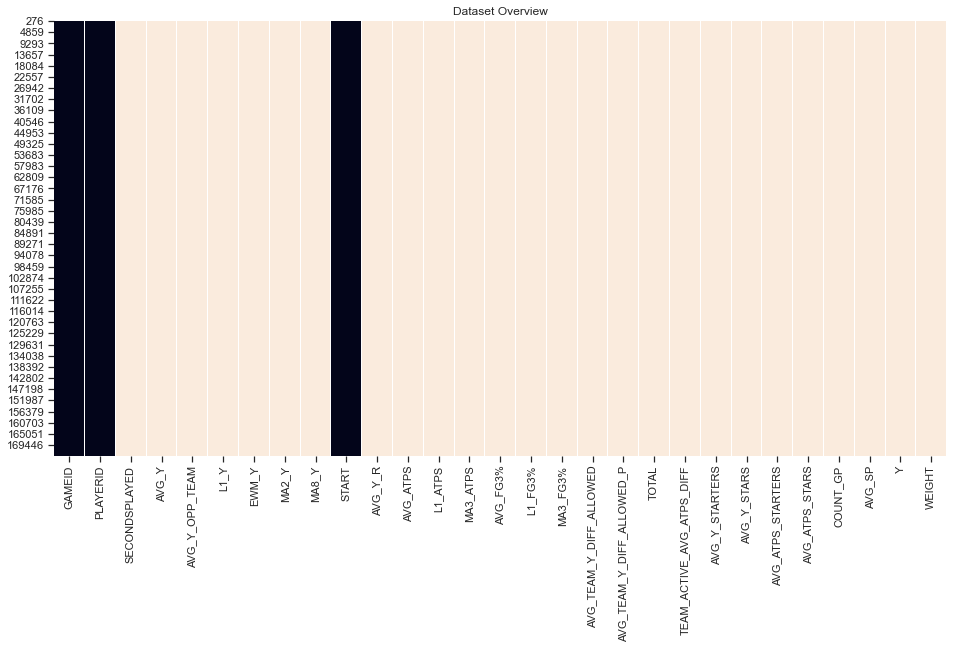

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [48]:
helpers.visualize_dataframe(feature_matrix)

# Model/Feature Selection
Finally, it's time to build the model. I will first iterate through various model types. Within each model iteration, I will isolate the important features. I will also try predicting the log transform of the dependant variable, and scaling the numeric columns, and pick whatever (Model, Feature Subset, \[Log Transform, No Transform\], \[Scale, No Scale\]) combination yeilds the lowest average MSE after 5-fold cross validation.

In [49]:
linear_models = [
    linear_model.LinearRegression(),
#     linear_model.Ridge(),
#     linear_model.ElasticNet()
]

neighbor_models = [
#     neighbors.KNeighborsRegressor()
]

boosted_models = [
    xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist'),
    CatBoostRegressor(eval_metric='MAE', learning_rate=0.1, n_estimators=500, silent=True)
    
]

neural_networks = [
    neural_network.MLPRegressor(max_iter=10000, early_stopping=True, random_state=42)
]

models = linear_models + neighbor_models + boosted_models + neural_networks

transformers = [
    {
        'Function': lambda x: x,
        'Inverse Function': lambda x: x,
        'Name': 'None'
    },
    {
        'Function': lambda x: np.log(x + 1),
        'Inverse Function': lambda x: np.exp(x) - 1,
        'Name': 'Log'
    }
]

numeric_regressors = list(set(regressors) - set(categorical_regressors))
numeric_columns = numeric_regressors + [y]

min_score = float('inf')
best_model = None
for model in models:
    for transformer in transformers:
        for scale in [False, True]:
            
            # transform numeric columns
            feature_matrix_t = feature_matrix.copy()
            feature_matrix_t[numeric_columns] = feature_matrix_t[numeric_columns].apply(
                transformer['Function'], axis=1
            )
            
            # scale numeric features
            if scale:
                x_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                feature_matrix_t[numeric_regressors] = x_scaler.fit_transform(feature_matrix_t[numeric_regressors])
                
                y_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                feature_matrix_t[[y]] = y_scaler.fit_transform(feature_matrix_t[[y]])

            # feature selection
            X = feature_matrix_t[regressors]
            Y = feature_matrix_t[y]
            W = feature_matrix_t[w]

            if model in (neighbor_models + neural_networks):
                selected_features = regressors.copy()
            else:
                model.fit(X, Y, sample_weight=W)
                
                # importance
                importance_selector = SelectFromModel(model, threshold='0.75*median')
                importance_selector = importance_selector.fit(X, Y, sample_weight=W)
                importance_support = importance_selector.get_support()
                
                # rank
                rank_selector = RFE(model)
                rank_selector = rank_selector.fit(X, Y)
                rank_support = rank_selector.ranking_
                median_rank = np.median(rank_support)
                
                selected_features = []
                for feature, importance_flag, rank in zip(list(X.columns), importance_support, rank_support):
                    # select the feature if it's important, or has a low rank
                    if importance_flag or (rank <= median_rank):
                        selected_features.append(feature)
            
            X = feature_matrix_t[selected_features].values
            Y = feature_matrix_t[y].values
            W = feature_matrix_t[w].values
            
            # cross validation
            scores = []
            cv = model_selection.KFold(n_splits=5, shuffle=True)
            for train, test in cv.split(X, Y, W):
                if model in (neural_networks + neighbor_models):
                    prediction = model.fit(X[train], Y[train]).predict(X[test])
                else:
                    prediction = model.fit(X[train], Y[train], sample_weight=W[train]).predict(X[test])
                true = Y[test]

                if scale:
                    prediction = y_scaler.inverse_transform(prediction.reshape(-1,1)).reshape(-1)
                    true = y_scaler.inverse_transform(true.reshape(-1,1)).reshape(-1)

                prediction = transformer['Inverse Function'](prediction)
                true = transformer['Inverse Function'](true)
                
                scores.append(metrics.mean_absolute_error(prediction, true, sample_weight=W[test]))

            mean_score = np.mean(scores)
            print('Model:', model)
            print('Transformer:', transformer['Name'])
            print('Scale:', scale)
            print('Selected Features:', selected_features)
            print('Mean MAE:', mean_score)
            print()
            if mean_score < min_score:
                min_score = mean_score
                best_model = (model, transformer['Name'], scale, selected_features)
print(best_model, min_score)

Model: LinearRegression()
Transformer: None
Scale: False
Selected Features: ['AVG_Y', 'L1_Y', 'EWM_Y', 'MA2_Y', 'MA8_Y', 'AVG_Y_R', 'AVG_ATPS', 'MA3_ATPS', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TEAM_ACTIVE_AVG_ATPS_DIFF', 'AVG_Y_STARTERS', 'AVG_Y_STARS', 'AVG_ATPS_STARTERS', 'AVG_ATPS_STARS']
Mean MAE: 0.0004885620769499689

Model: LinearRegression()
Transformer: None
Scale: True
Selected Features: ['AVG_Y', 'EWM_Y', 'MA2_Y', 'MA8_Y', 'START', 'AVG_Y_R', 'AVG_ATPS', 'MA3_ATPS', 'L1_FG3%', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'AVG_Y_STARS', 'AVG_ATPS_STARTERS', 'AVG_ATPS_STARS', 'COUNT_GP', 'AVG_SP']
Mean MAE: 0.0004888154099767054

Model: LinearRegression()
Transformer: Log
Scale: False
Selected Features: ['AVG_Y', 'EWM_Y', 'MA2_Y', 'MA8_Y', 'AVG_Y_R', 'AVG_ATPS', 'MA3_ATPS', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TEAM_ACTIVE_AVG_ATPS_DIFF', 'AVG_Y_STARTERS', 'AVG_Y_STARS', 'AVG_ATPS_STARTERS', 'AVG_ATPS_STARS']
Mean MAE: 0.000488

Model: MLPRegressor(early_stopping=True, max_iter=10000, random_state=42)
Transformer: Log
Scale: True
Selected Features: ['AVG_Y', 'AVG_Y_OPP_TEAM', 'L1_Y', 'EWM_Y', 'MA2_Y', 'MA8_Y', 'START', 'AVG_Y_R', 'AVG_ATPS', 'L1_ATPS', 'MA3_ATPS', 'AVG_FG3%', 'L1_FG3%', 'MA3_FG3%', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TOTAL', 'TEAM_ACTIVE_AVG_ATPS_DIFF', 'AVG_Y_STARTERS', 'AVG_Y_STARS', 'AVG_ATPS_STARTERS', 'AVG_ATPS_STARS', 'COUNT_GP', 'AVG_SP']
Mean MAE: 0.0004903178329416626

(XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subs

The best model is a Catboost model with no log transformations or scaling.

# Parameter Tuning
Now, I will use Grid Search Cross Validation to find the CatBoostRegressor paramters that yeild the lowest average MSE on the test set.

In [52]:
selected_features = ['AVG_Y', 'AVG_Y_OPP_TEAM', 'EWM_Y', 'MA2_Y', 'MA8_Y', 'AVG_Y_R', 'AVG_ATPS', 'L1_ATPS',
                     'MA3_ATPS', 'AVG_FG3%', 'MA3_FG3%', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P',
                     'TOTAL', 'TEAM_ACTIVE_AVG_ATPS_DIFF', 'AVG_Y_STARTERS', 'AVG_Y_STARS', 'AVG_ATPS_STARTERS',
                     'AVG_ATPS_STARS', 'COUNT_GP', 'AVG_SP']
# selected_features = best_model[3]
X = feature_matrix[selected_features]
Y = feature_matrix[y]
W = feature_matrix[w]
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, test_size=0.25, random_state=1)

In [53]:
model = CatBoostRegressor()

model_params = {
    'depth': [4, 6, 8, 10],
    'learning_rate' : [0.01, 0.02, 0.05, 0.1],
    'num_boost_round': [5000],
    'eval_metric': ['MAE']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 25,
    "eval_set": (X_test, y_test),
    'sample_weight': w_train
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

0:	learn: 0.0006424	test: 0.0006820	best: 0.0006820 (0)	total: 45.1ms	remaining: 3m 45s
1:	learn: 0.0006384	test: 0.0006781	best: 0.0006781 (1)	total: 94.5ms	remaining: 3m 56s
2:	learn: 0.0006346	test: 0.0006743	best: 0.0006743 (2)	total: 170ms	remaining: 4m 43s
3:	learn: 0.0006308	test: 0.0006706	best: 0.0006706 (3)	total: 213ms	remaining: 4m 26s
4:	learn: 0.0006272	test: 0.0006670	best: 0.0006670 (4)	total: 258ms	remaining: 4m 18s
5:	learn: 0.0006236	test: 0.0006634	best: 0.0006634 (5)	total: 309ms	remaining: 4m 16s
6:	learn: 0.0006201	test: 0.0006599	best: 0.0006599 (6)	total: 392ms	remaining: 4m 39s
7:	learn: 0.0006167	test: 0.0006565	best: 0.0006565 (7)	total: 442ms	remaining: 4m 36s
8:	learn: 0.0006134	test: 0.0006533	best: 0.0006533 (8)	total: 494ms	remaining: 4m 34s
9:	learn: 0.0006101	test: 0.0006501	best: 0.0006501 (9)	total: 544ms	remaining: 4m 31s
10:	learn: 0.0006071	test: 0.0006470	best: 0.0006470 (10)	total: 595ms	remaining: 4m 29s
11:	learn: 0.0006040	test: 0.0006440	be

96:	learn: 0.0005005	test: 0.0005391	best: 0.0005391 (96)	total: 5.53s	remaining: 4m 39s
97:	learn: 0.0005001	test: 0.0005387	best: 0.0005387 (97)	total: 5.58s	remaining: 4m 39s
98:	learn: 0.0004997	test: 0.0005383	best: 0.0005383 (98)	total: 5.67s	remaining: 4m 40s
99:	learn: 0.0004993	test: 0.0005379	best: 0.0005379 (99)	total: 5.71s	remaining: 4m 39s
100:	learn: 0.0004990	test: 0.0005375	best: 0.0005375 (100)	total: 5.76s	remaining: 4m 39s
101:	learn: 0.0004986	test: 0.0005372	best: 0.0005372 (101)	total: 5.85s	remaining: 4m 40s
102:	learn: 0.0004982	test: 0.0005368	best: 0.0005368 (102)	total: 5.89s	remaining: 4m 40s
103:	learn: 0.0004979	test: 0.0005365	best: 0.0005365 (103)	total: 5.94s	remaining: 4m 39s
104:	learn: 0.0004976	test: 0.0005362	best: 0.0005362 (104)	total: 6.02s	remaining: 4m 40s
105:	learn: 0.0004973	test: 0.0005359	best: 0.0005359 (105)	total: 6.07s	remaining: 4m 40s
106:	learn: 0.0004969	test: 0.0005355	best: 0.0005355 (106)	total: 6.12s	remaining: 4m 39s
107:	le

187:	learn: 0.0004816	test: 0.0005220	best: 0.0005220 (187)	total: 10.6s	remaining: 4m 30s
188:	learn: 0.0004815	test: 0.0005219	best: 0.0005219 (188)	total: 10.6s	remaining: 4m 30s
189:	learn: 0.0004814	test: 0.0005218	best: 0.0005218 (189)	total: 10.7s	remaining: 4m 29s
190:	learn: 0.0004813	test: 0.0005218	best: 0.0005218 (190)	total: 10.7s	remaining: 4m 29s
191:	learn: 0.0004812	test: 0.0005217	best: 0.0005217 (191)	total: 10.8s	remaining: 4m 30s
192:	learn: 0.0004811	test: 0.0005217	best: 0.0005217 (192)	total: 10.8s	remaining: 4m 30s
193:	learn: 0.0004810	test: 0.0005216	best: 0.0005216 (193)	total: 10.9s	remaining: 4m 30s
194:	learn: 0.0004809	test: 0.0005215	best: 0.0005215 (194)	total: 11s	remaining: 4m 30s
195:	learn: 0.0004808	test: 0.0005214	best: 0.0005214 (195)	total: 11s	remaining: 4m 30s
196:	learn: 0.0004807	test: 0.0005214	best: 0.0005214 (196)	total: 11.1s	remaining: 4m 29s
197:	learn: 0.0004806	test: 0.0005213	best: 0.0005213 (197)	total: 11.1s	remaining: 4m 29s
198

278:	learn: 0.0004748	test: 0.0005190	best: 0.0005190 (278)	total: 15.5s	remaining: 4m 22s
279:	learn: 0.0004747	test: 0.0005190	best: 0.0005190 (279)	total: 15.6s	remaining: 4m 22s
280:	learn: 0.0004746	test: 0.0005190	best: 0.0005190 (280)	total: 15.6s	remaining: 4m 22s
281:	learn: 0.0004746	test: 0.0005190	best: 0.0005190 (281)	total: 15.7s	remaining: 4m 22s
282:	learn: 0.0004745	test: 0.0005190	best: 0.0005190 (281)	total: 15.7s	remaining: 4m 22s
283:	learn: 0.0004745	test: 0.0005190	best: 0.0005190 (283)	total: 15.8s	remaining: 4m 22s
284:	learn: 0.0004744	test: 0.0005190	best: 0.0005190 (284)	total: 15.8s	remaining: 4m 22s
285:	learn: 0.0004744	test: 0.0005189	best: 0.0005189 (285)	total: 15.9s	remaining: 4m 22s
286:	learn: 0.0004743	test: 0.0005189	best: 0.0005189 (286)	total: 16s	remaining: 4m 22s
287:	learn: 0.0004742	test: 0.0005189	best: 0.0005189 (287)	total: 16s	remaining: 4m 22s
288:	learn: 0.0004742	test: 0.0005189	best: 0.0005189 (288)	total: 16.1s	remaining: 4m 21s
289

372:	learn: 0.0004698	test: 0.0005183	best: 0.0005183 (372)	total: 20.6s	remaining: 4m 16s
373:	learn: 0.0004698	test: 0.0005183	best: 0.0005183 (373)	total: 20.7s	remaining: 4m 15s
374:	learn: 0.0004697	test: 0.0005183	best: 0.0005183 (374)	total: 20.7s	remaining: 4m 15s
375:	learn: 0.0004697	test: 0.0005183	best: 0.0005183 (375)	total: 20.8s	remaining: 4m 15s
376:	learn: 0.0004696	test: 0.0005183	best: 0.0005183 (376)	total: 20.8s	remaining: 4m 15s
377:	learn: 0.0004696	test: 0.0005183	best: 0.0005183 (377)	total: 20.9s	remaining: 4m 15s
378:	learn: 0.0004695	test: 0.0005183	best: 0.0005183 (378)	total: 21s	remaining: 4m 16s
379:	learn: 0.0004695	test: 0.0005183	best: 0.0005183 (378)	total: 21.1s	remaining: 4m 16s
380:	learn: 0.0004694	test: 0.0005183	best: 0.0005183 (378)	total: 21.1s	remaining: 4m 15s
381:	learn: 0.0004694	test: 0.0005183	best: 0.0005183 (381)	total: 21.2s	remaining: 4m 15s
382:	learn: 0.0004693	test: 0.0005183	best: 0.0005183 (382)	total: 21.2s	remaining: 4m 15s
3

# Evaluation
Lastly, I will evaluate the final model.

In [54]:
best_params = grid.best_params_
model = CatBoostRegressor(**best_params)

weighted_eval_set = Pool(
    data=X_test,
    label=y_test,
    weight=w_test
)
fit_params['eval_set'] = weighted_eval_set

model.fit(X_train, y_train, **fit_params)

y_hat = model.predict(X_test)

0:	learn: 0.0006424	test: 0.0006451	best: 0.0006451 (0)	total: 47.8ms	remaining: 3m 59s
1:	learn: 0.0006384	test: 0.0006411	best: 0.0006411 (1)	total: 97.8ms	remaining: 4m 4s
2:	learn: 0.0006346	test: 0.0006373	best: 0.0006373 (2)	total: 151ms	remaining: 4m 11s
3:	learn: 0.0006308	test: 0.0006335	best: 0.0006335 (3)	total: 202ms	remaining: 4m 12s
4:	learn: 0.0006272	test: 0.0006298	best: 0.0006298 (4)	total: 254ms	remaining: 4m 13s
5:	learn: 0.0006236	test: 0.0006262	best: 0.0006262 (5)	total: 304ms	remaining: 4m 13s
6:	learn: 0.0006201	test: 0.0006227	best: 0.0006227 (6)	total: 357ms	remaining: 4m 14s
7:	learn: 0.0006167	test: 0.0006193	best: 0.0006193 (7)	total: 409ms	remaining: 4m 15s
8:	learn: 0.0006134	test: 0.0006159	best: 0.0006159 (8)	total: 465ms	remaining: 4m 17s
9:	learn: 0.0006101	test: 0.0006127	best: 0.0006127 (9)	total: 552ms	remaining: 4m 35s
10:	learn: 0.0006071	test: 0.0006096	best: 0.0006096 (10)	total: 658ms	remaining: 4m 58s
11:	learn: 0.0006040	test: 0.0006066	bes

96:	learn: 0.0005005	test: 0.0005038	best: 0.0005038 (96)	total: 6.05s	remaining: 5m 5s
97:	learn: 0.0005001	test: 0.0005035	best: 0.0005035 (97)	total: 6.1s	remaining: 5m 5s
98:	learn: 0.0004997	test: 0.0005031	best: 0.0005031 (98)	total: 6.15s	remaining: 5m 4s
99:	learn: 0.0004993	test: 0.0005028	best: 0.0005028 (99)	total: 6.2s	remaining: 5m 3s
100:	learn: 0.0004990	test: 0.0005024	best: 0.0005024 (100)	total: 6.24s	remaining: 5m 2s
101:	learn: 0.0004986	test: 0.0005021	best: 0.0005021 (101)	total: 6.3s	remaining: 5m 2s
102:	learn: 0.0004982	test: 0.0005018	best: 0.0005018 (102)	total: 6.35s	remaining: 5m 1s
103:	learn: 0.0004979	test: 0.0005015	best: 0.0005015 (103)	total: 6.39s	remaining: 5m 1s
104:	learn: 0.0004976	test: 0.0005012	best: 0.0005012 (104)	total: 6.44s	remaining: 5m
105:	learn: 0.0004973	test: 0.0005009	best: 0.0005009 (105)	total: 6.49s	remaining: 4m 59s
106:	learn: 0.0004969	test: 0.0005006	best: 0.0005006 (106)	total: 6.54s	remaining: 4m 59s
107:	learn: 0.0004966	

188:	learn: 0.0004815	test: 0.0004881	best: 0.0004881 (188)	total: 10.8s	remaining: 4m 35s
189:	learn: 0.0004814	test: 0.0004880	best: 0.0004880 (189)	total: 10.9s	remaining: 4m 35s
190:	learn: 0.0004813	test: 0.0004880	best: 0.0004880 (190)	total: 10.9s	remaining: 4m 35s
191:	learn: 0.0004812	test: 0.0004879	best: 0.0004879 (191)	total: 11s	remaining: 4m 34s
192:	learn: 0.0004811	test: 0.0004878	best: 0.0004878 (192)	total: 11s	remaining: 4m 34s
193:	learn: 0.0004810	test: 0.0004878	best: 0.0004878 (193)	total: 11.1s	remaining: 4m 35s
194:	learn: 0.0004809	test: 0.0004877	best: 0.0004877 (194)	total: 11.2s	remaining: 4m 34s
195:	learn: 0.0004808	test: 0.0004876	best: 0.0004876 (195)	total: 11.2s	remaining: 4m 34s
196:	learn: 0.0004807	test: 0.0004876	best: 0.0004876 (196)	total: 11.3s	remaining: 4m 34s
197:	learn: 0.0004806	test: 0.0004875	best: 0.0004875 (197)	total: 11.3s	remaining: 4m 34s
198:	learn: 0.0004805	test: 0.0004874	best: 0.0004874 (198)	total: 11.3s	remaining: 4m 33s
199

283:	learn: 0.0004745	test: 0.0004854	best: 0.0004854 (283)	total: 15.6s	remaining: 4m 18s
284:	learn: 0.0004744	test: 0.0004854	best: 0.0004854 (284)	total: 15.7s	remaining: 4m 19s
285:	learn: 0.0004744	test: 0.0004853	best: 0.0004853 (285)	total: 15.7s	remaining: 4m 18s
286:	learn: 0.0004743	test: 0.0004853	best: 0.0004853 (286)	total: 15.8s	remaining: 4m 18s
287:	learn: 0.0004742	test: 0.0004853	best: 0.0004853 (287)	total: 15.8s	remaining: 4m 18s
288:	learn: 0.0004742	test: 0.0004853	best: 0.0004853 (287)	total: 15.9s	remaining: 4m 18s
289:	learn: 0.0004741	test: 0.0004853	best: 0.0004853 (287)	total: 15.9s	remaining: 4m 18s
290:	learn: 0.0004741	test: 0.0004853	best: 0.0004853 (290)	total: 16s	remaining: 4m 18s
291:	learn: 0.0004740	test: 0.0004853	best: 0.0004853 (291)	total: 16s	remaining: 4m 18s
292:	learn: 0.0004740	test: 0.0004853	best: 0.0004853 (292)	total: 16.1s	remaining: 4m 18s
293:	learn: 0.0004740	test: 0.0004853	best: 0.0004853 (293)	total: 16.1s	remaining: 4m 18s
294

375:	learn: 0.0004697	test: 0.0004848	best: 0.0004848 (375)	total: 20.2s	remaining: 4m 9s
376:	learn: 0.0004696	test: 0.0004848	best: 0.0004848 (376)	total: 20.3s	remaining: 4m 8s
377:	learn: 0.0004696	test: 0.0004848	best: 0.0004848 (377)	total: 20.3s	remaining: 4m 8s
378:	learn: 0.0004695	test: 0.0004848	best: 0.0004848 (378)	total: 20.4s	remaining: 4m 8s
379:	learn: 0.0004695	test: 0.0004848	best: 0.0004848 (378)	total: 20.4s	remaining: 4m 8s
380:	learn: 0.0004694	test: 0.0004848	best: 0.0004848 (378)	total: 20.5s	remaining: 4m 8s
381:	learn: 0.0004694	test: 0.0004848	best: 0.0004848 (381)	total: 20.5s	remaining: 4m 8s
382:	learn: 0.0004693	test: 0.0004848	best: 0.0004848 (381)	total: 20.6s	remaining: 4m 8s
383:	learn: 0.0004693	test: 0.0004848	best: 0.0004848 (381)	total: 20.6s	remaining: 4m 8s
384:	learn: 0.0004692	test: 0.0004848	best: 0.0004848 (381)	total: 20.7s	remaining: 4m 7s
385:	learn: 0.0004692	test: 0.0004848	best: 0.0004848 (381)	total: 20.7s	remaining: 4m 7s
386:	learn

First, I will visualize the feature importances.

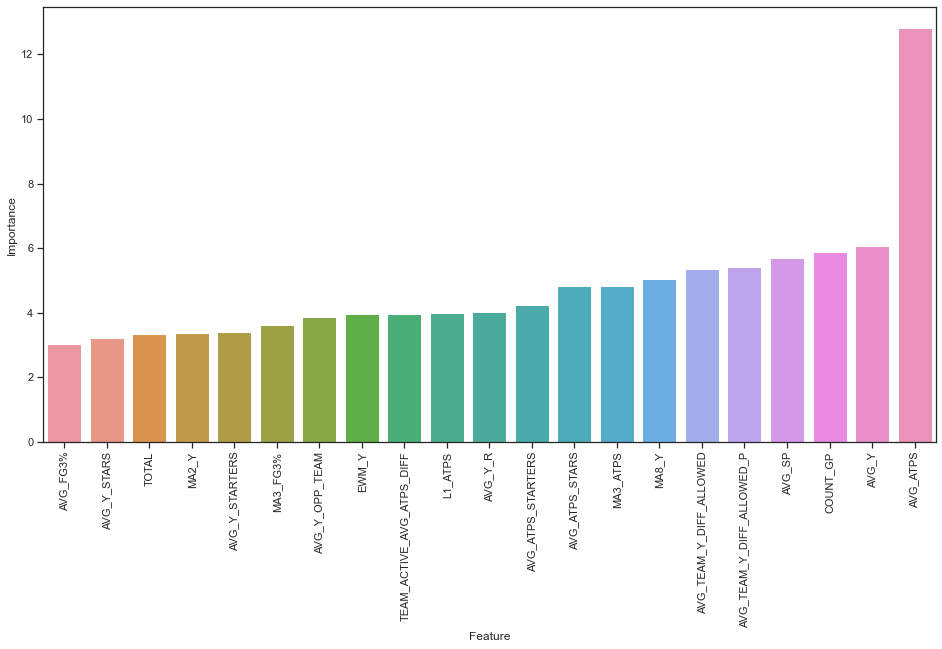

In [55]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
ax = sns.barplot(x="Feature", y="Importance", data=feature_importance_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

I will calculate a few metrics to evaluate the model's predictive power.

In [56]:
y_avg = feature_matrix.loc[X_test.index, 'AVG_Y']

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat, sample_weight=w_test), 3))
print("Baseline:", round(metrics.r2_score(y_test, y_avg, sample_weight=w_test), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat, sample_weight=w_test), 6))
print("Baseline:", round(metrics.mean_absolute_error(y_test, y_avg, sample_weight=w_test), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat, sample_weight=w_test)), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(y_test, y_avg, sample_weight=w_test)), 6))

R2 (explained variance):
Model: 0.302
Baseline: 0.276

Mean Absolute Error (Σ|y-pred|/n):
Model: 0.000486
Baseline: 0.000488

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 0.000682
Baseline: 0.000694


Residual analysis:

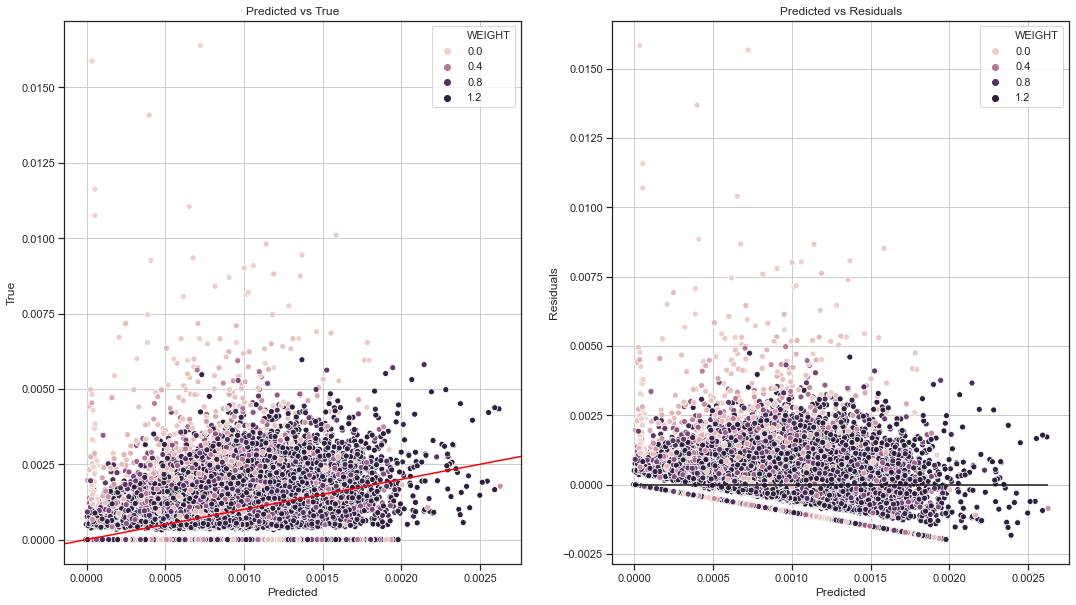

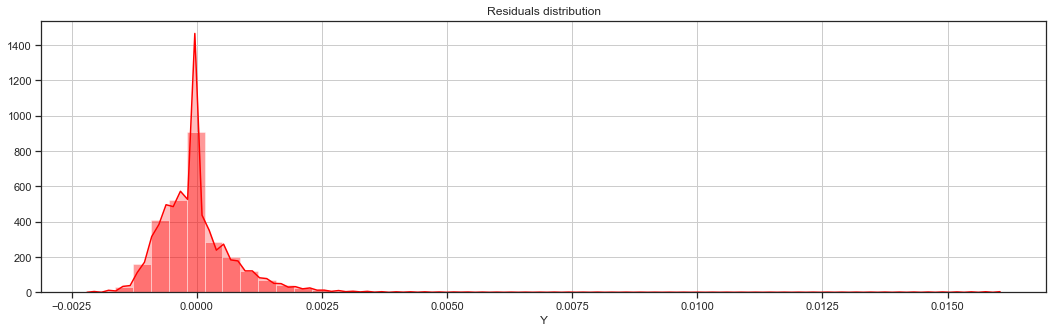

In [57]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, hue=w_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, hue=w_test, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()

In [58]:
stat, p = shapiro(residuals)
print(stat, p)

0.8521080017089844 0.0


Residuals are normally distributed and not heteroskedastic.